# IY007 CV Analysis

Comparing specified CV vs observed CV in synthetic data

In IY007.py, we generate synthetic data with specific CV (Coefficient of Variation) targets. The CV is specified as a ratio between stress and normal conditions. This script will:

1. Load the synthetic data generated by IY007.py
2. Calculate the observed CV from the actual data
3. Compare the observed CV to the CV that was specified in the parameters
4. Plot the specified CV against the observed CV to check how well they match

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from tqdm import tqdm

# Import autocorrelation functions
import sys
from stats.cv import calculate_cv
%load_ext autoreload
%autoreload 2

## Load the Time Series Data

In [ ]:
def load_cv_data(data_dir):
    """Load CV data from IY007 simulation results"""
    cv_data = []
    
    # Find all CV trajectory directories (they follow pattern mRNA_trajectories_cv_X.XX_Y.YY)
    pattern = os.path.join(data_dir, 'mRNA_trajectories_cv_*_*')
    cv_dirs = glob.glob(pattern)
    
    if not cv_dirs:
        print(f"No CV trajectory directories found in {data_dir}")
        return None
    
    print(f"Found {len(cv_dirs)} CV trajectory directories")
    
    for cv_dir in tqdm(cv_dirs, desc="Processing CV directories"):
        # Extract CV values from directory name
        dir_name = os.path.basename(cv_dir)
        cv_parts = dir_name.split('_')
        cv_stress = float(cv_parts[-2])  # Second to last part is stress CV
        cv_normal = float(cv_parts[-1])  # Last part is normal CV
        cv_ratio = cv_stress / cv_normal
        
        # Find the steady state directory
        steady_state_dir = os.path.join(cv_dir, 'steady_state_trajectories')
        if not os.path.exists(steady_state_dir):
            print(f"Steady state directory not found in {cv_dir}")
            continue
        
        # Process each file in the steady state, integer timepoint directory
        ss_files = glob.glob(os.path.join(steady_state_dir, '*_SS_integer.csv'))
        
        if not ss_files:
            print(f"No steady state files found in {steady_state_dir}")
            continue
        
        # only process those with normal CV = 0.5 (for IY007_6)
        if cv_normal == 0.5:
            
            # Process each steady state, integer timepoint file
            for ss_file in ss_files:
                try:
                    # Load the steady state data
                    df = pd.read_csv(ss_file)
                    
                    # Split data by condition
                    stress_data = df[df['label'] == 0].iloc[:, 1:].values
                    normal_data = df[df['label'] == 1].iloc[:, 1:].values
                    
                    # Calculate observed statistics for each condition
                    stress_mean = np.nanmean(stress_data)
                    stress_variance = np.nanvar(stress_data)
                    normal_mean = np.nanmean(normal_data)
                    normal_variance = np.nanvar(normal_data)

                    # Calculate observed CVs
                    observed_cv_stress = calculate_cv(stress_variance, stress_mean)
                    observed_cv_normal = calculate_cv(normal_variance, normal_mean)
                    observed_cv_ratio = observed_cv_stress / observed_cv_normal
                    
                    # Store results
                    cv_data.append({
                        'specified_cv_stress': cv_stress,
                        'specified_cv_normal': cv_normal,
                        'specified_cv_ratio': cv_ratio,
                        'observed_cv_stress': observed_cv_stress,
                        'observed_cv_normal': observed_cv_normal,
                        'observed_cv_ratio': observed_cv_ratio,
                        'stress_mean': stress_mean,
                        'stress_variance': stress_variance,
                        'normal_mean': normal_mean,
                        'normal_variance': normal_variance
                    })
                    
                except Exception as e:
                    print(f"Error processing {ss_file}: {e}")
            else:
                continue
        
    # Convert to DataFrame
    return pd.DataFrame(cv_data)

In [4]:
# Define path to the data directory containing IY007 output
data_dir = '/home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/'

# Load the CV data
cv_df = load_cv_data(data_dir)

if cv_df is not None and not cv_df.empty:
    print(f"Loaded data for {len(cv_df)} simulations")
    
    # Group by specified CV ratio to calculate mean and std of observed values
    grouped_df = cv_df.groupby('specified_cv_ratio').agg({
        'observed_cv_ratio': ['mean', 'std'],
        'observed_cv_stress': ['mean', 'std'],
        'observed_cv_normal': ['mean', 'std']
    }).reset_index()
    
    # Flatten the multi-level columns
    grouped_df.columns = ['_'.join(col).strip('_') for col in grouped_df.columns.values]
    
    print(f"Data grouped into {len(grouped_df)} unique CV ratios")
    
    # Sort by specified CV ratio
    grouped_df = grouped_df.sort_values('specified_cv_ratio')
else:
    print("No data available for analysis")

Found 123 CV trajectory directories


Processing CV directories:   0%|          | 0/123 [00:00<?, ?it/s]

Processing CV directories:   2%|▏         | 2/123 [00:00<00:07, 16.87it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.59_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.35_0.32/steady_state_trajectories


Processing CV directories:  13%|█▎        | 16/123 [00:00<00:03, 27.52it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.50_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.27_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.42_0.32/steady_state_trajectories


Processing CV directories:  20%|██        | 25/123 [00:01<00:03, 25.16it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.19_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.38_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.43_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.57_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.46_0.32/steady_state_trajectories


Processing CV directories:  29%|██▉       | 36/123 [00:01<00:02, 37.07it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.54_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.49_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.16_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.18_0.32/steady_state_trajectories


Processing CV directories:  38%|███▊      | 47/123 [00:01<00:02, 26.79it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.52_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.60_0.32/steady_state_trajectories


Processing CV directories:  47%|████▋     | 58/123 [00:02<00:02, 29.48it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.58_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.51_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.25_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.36_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.24_0.32/steady_state_trajectories


Processing CV directories:  53%|█████▎    | 65/123 [00:02<00:02, 27.32it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.39_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.28_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.30_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.22_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.14_0.25/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.63_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/ex

Processing CV directories:  63%|██████▎   | 78/123 [00:02<00:01, 31.87it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.34_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.17_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.33_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.61_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.55_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.23_0.32/steady_state_trajectories


Processing CV directories:  73%|███████▎  | 90/123 [00:03<00:00, 35.80it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.20_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.26_0.32/steady_state_trajectories


Processing CV directories:  77%|███████▋  | 95/123 [00:03<00:00, 38.08it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.45_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.47_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.31_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.29_0.32/steady_state_trajectories


Processing CV directories:  85%|████████▍ | 104/123 [00:03<00:00, 35.13it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.41_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.32_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.56_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.53_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.62_0.32/steady_state_trajectories


Processing CV directories:  94%|█████████▍| 116/123 [00:03<00:00, 31.62it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.48_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.21_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.64_0.32/steady_state_trajectories
No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.40_0.32/steady_state_trajectories


Processing CV directories: 100%|██████████| 123/123 [00:04<00:00, 29.75it/s]

No steady state files found in /home/ianyang/stochastic_simulations/experiments/EXP-25-IY007/data/mRNA_trajectories_cv_0.37_0.32/steady_state_trajectories
Loaded data for 730 simulations
Data grouped into 73 unique CV ratios


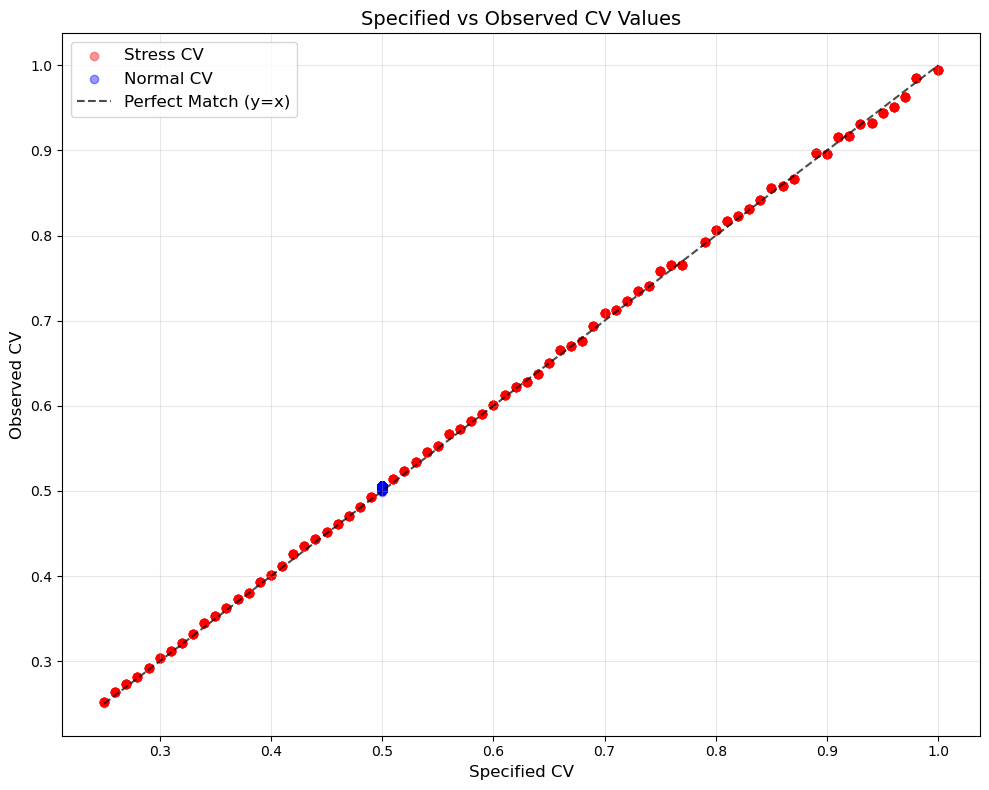

In [ ]:
if 'grouped_df' in locals() and not grouped_df.empty:
    # Combined plot to see all data together
    plt.figure(figsize=(10, 8))
    plt.scatter(
        cv_df['specified_cv_stress'], 
        cv_df['observed_cv_stress'],
        color='red', alpha=0.4, label='Stress CV'
    )
    plt.scatter(
        cv_df['specified_cv_normal'], 
        cv_df['observed_cv_normal'],
        color='blue', alpha=0.4, label='Normal CV'
    )
    # use min and max of all CVs to set a dash line showing the perfect match
    min_val = min(cv_df['specified_cv_stress'].min(), cv_df['specified_cv_normal'].min(), 
                  cv_df['observed_cv_stress'].min(), cv_df['observed_cv_normal'].min())
    max_val = max(cv_df['specified_cv_stress'].max(), cv_df['specified_cv_normal'].max(),
                  cv_df['observed_cv_stress'].max(), cv_df['observed_cv_normal'].max())
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.7, label='Perfect Match (y=x)')
    plt.xlabel('Specified CV', fontsize=12)
    plt.ylabel('Observed CV', fontsize=12)
    plt.title('Specified vs Observed CV Values', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.savefig("combined_specified_vs_observed_cv.png", dpi=300)
    plt.show()



Summary Statistics for CV Ratio Simulation Accuracy:
Mean Absolute Error: 0.0080
Mean Percentage Error: 0.61%
Median Absolute Error: 0.0059
Median Percentage Error: 0.52%


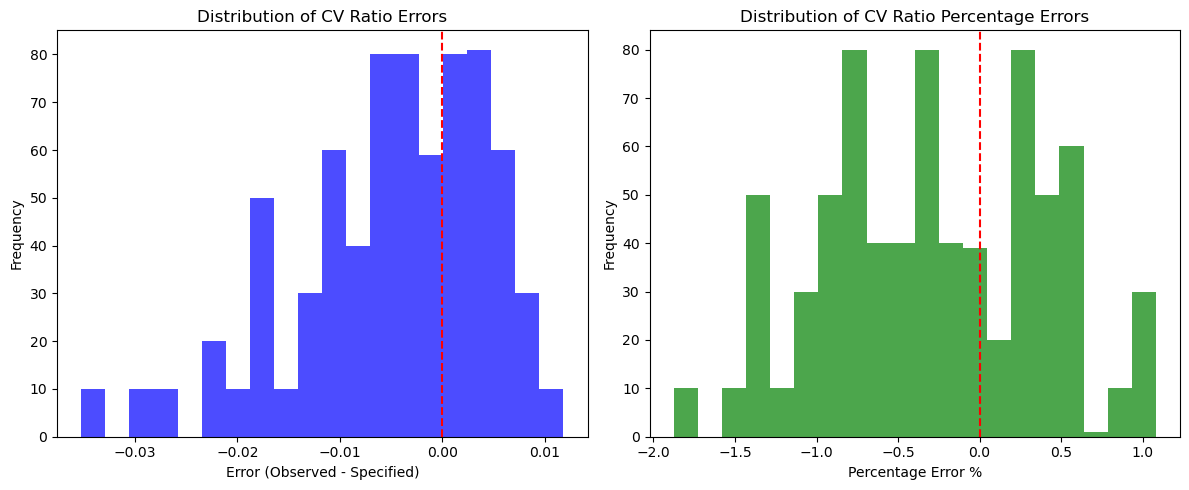

In [12]:
if 'cv_df' in locals() and not cv_df.empty:
    # Calculate error metrics
    cv_df['ratio_error'] = cv_df['observed_cv_ratio'] - cv_df['specified_cv_ratio']
    cv_df['ratio_pct_error'] = (cv_df['ratio_error'] / cv_df['specified_cv_ratio']) * 100
    
    # Calculate summary statistics
    mean_abs_error = np.abs(cv_df['ratio_error']).mean()
    mean_pct_error = np.abs(cv_df['ratio_pct_error']).mean()
    median_abs_error = np.median(np.abs(cv_df['ratio_error']))
    median_pct_error = np.median(np.abs(cv_df['ratio_pct_error']))
    
    print("\nSummary Statistics for CV Ratio Simulation Accuracy:")
    print(f"Mean Absolute Error: {mean_abs_error:.4f}")
    print(f"Mean Percentage Error: {mean_pct_error:.2f}%")
    print(f"Median Absolute Error: {median_abs_error:.4f}")
    print(f"Median Percentage Error: {median_pct_error:.2f}%")
    
    # Show the distribution of errors
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.hist(cv_df['ratio_error'], bins=20, alpha=0.7, color='blue')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Error (Observed - Specified)')
    plt.ylabel('Frequency')
    plt.title('Distribution of CV Ratio Errors')
    
    plt.subplot(1, 2, 2)
    plt.hist(cv_df['ratio_pct_error'], bins=20, alpha=0.7, color='green')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel('Percentage Error %')
    plt.ylabel('Frequency')
    plt.title('Distribution of CV Ratio Percentage Errors')
    
    plt.tight_layout()
    plt.savefig("cv_error_distributions.png", dpi=300)
    plt.show()

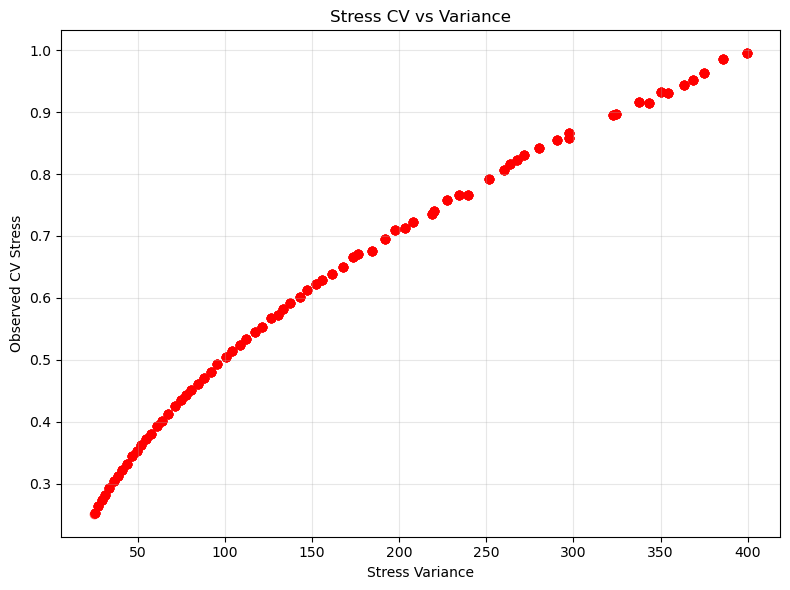

In [ ]:
if 'cv_df' in locals() and not cv_df.empty:
    plt.figure(figsize=(8, 6))
    plt.scatter(cv_df['stress_variance'], cv_df['observed_cv_stress'], alpha=0.6, color='red')
    plt.xlabel('Stress Variance')
    plt.ylabel('Observed CV Stress')
    plt.title('Stress CV vs Variance')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig("cv_stress_vs_variance.png", dpi=300)
    plt.show()

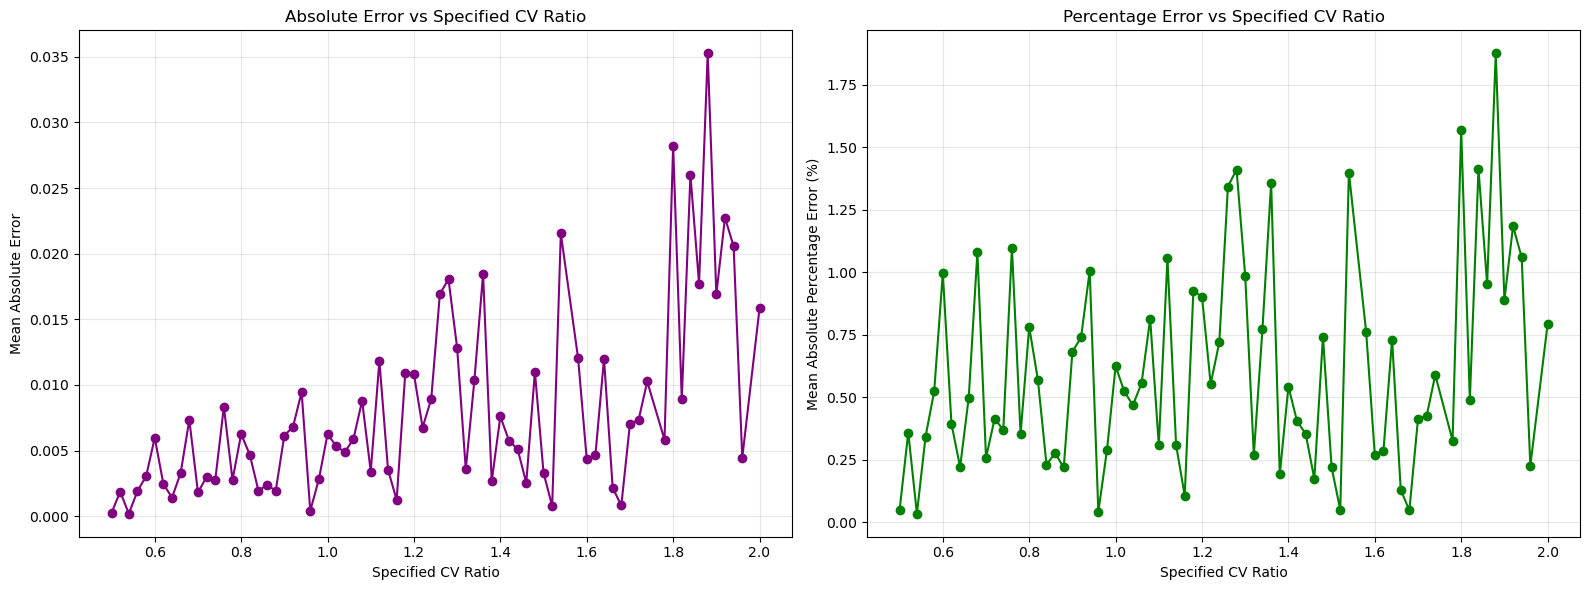

In [14]:
if 'grouped_df' in locals() and not grouped_df.empty:
    # Calculate ratio error and percentage error
    grouped_df['ratio_error_mean'] = grouped_df['observed_cv_ratio_mean'] - grouped_df['specified_cv_ratio']
    grouped_df['ratio_pct_error_mean'] = (grouped_df['ratio_error_mean'] / grouped_df['specified_cv_ratio']) * 100
    
    # Plot error trends
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Absolute Error vs Specified CV Ratio
    axes[0].plot(grouped_df['specified_cv_ratio'], np.abs(grouped_df['ratio_error_mean']), 'o-', color='purple')
    axes[0].set_xlabel('Specified CV Ratio')
    axes[0].set_ylabel('Mean Absolute Error')
    axes[0].set_title('Absolute Error vs Specified CV Ratio')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Percentage Error vs Specified CV Ratio
    axes[1].plot(grouped_df['specified_cv_ratio'], np.abs(grouped_df['ratio_pct_error_mean']), 'o-', color='green')
    axes[1].set_xlabel('Specified CV Ratio')
    axes[1].set_ylabel('Mean Absolute Percentage Error (%)')
    axes[1].set_title('Percentage Error vs Specified CV Ratio')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig("cv_error_trends.png", dpi=300)
    plt.show()

## Conclusion

This analysis provides insights into how well the CV values specified in the simulation parameters match the actual CV values observed in the generated data. The key findings include:

1. How closely the observed CV ratios match the specified CV ratios
2. Whether there are systematic biases or errors in the CV simulation
3. How the accuracy varies across different CV ratio values
4. The relationships between CV, mean, and variance in the simulated data

These insights can help validate the simulation approach in IY007.py and identify any potential issues that need to be addressed in the model or parameter selection.